# LAPD lab - Machine learning project

This project aims to predict the GHI two hours in advance locally, from meteo data, date data and webcam images.

We are providing a machine learning model to achieve this task.

## Environnement and data loading

First, we import all important packages, data, and set the seed (for torch).

In [72]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import h5py
import sys
import datetime
import math
import random

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.data.sampler import SequentialSampler
from torchvision import transforms, utils
import cv2

from datetime import datetime

from google.colab import files ### file.download() to download a file from colab instead of right clicking

In [73]:
# Set fixed random number seed
torch.manual_seed(3174)

In [74]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
#path = 'drive/MyDrive/Colab Notebooks/CSS 433/data' #antonin
path = 'drive/MyDrive/master/CSS 433/data' #Jade
#path = 'drive/MyDrive/data' #Jade ordi 2
#path = 'drive/MyDrive/CSS 433/data' #Alison

for file in os.listdir(path):
  print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time.npy
new_irradiance.xlsx
persistent_level.npy
ground_truth.npy
labels.npy
meteo.xlsx
X.npy


In [52]:
# IMAGE DATA
#time_image = np.load(os.path.join(path, 'time.npy'),allow_pickle=True)
#ground_truth = np.load(os.path.join(path, 'ground_truth.npy'),allow_pickle=True)
#labels = ghi_dataset.labels

# Extract day, month, and year using list comprehension
#date_info_image = [(dt.day, dt.month, dt.year) if isinstance(dt, datetime) else
#                   (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
#                    datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
#                    datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year)
#                   for dt in time_image]

# List comprehension to extract day values for all dates
#day_values_image = [day for day, _, _ in date_info_image]
#month_values_image = [month for _, month, _ in date_info_image]
#year_values_image = [year for _ , _, year in date_info_image]
#month_and_year_values_image = [(month, year) for _, month, year in date_info_image]

# METEO DATA
# Construct the full path to the Excel file
#file_path = os.path.join(path, 'meteo.xlsx')
# Use pandas to read the Excel file
#df = pd.read_excel(file_path)

#date = df['Date'].values
#time_meteo = df['Time'].values
#real_time_ch = df['Real_time_CH'].values
#air_temp = df['Air_temp'].values
#wind_speed = df['Wind_speed'].values
#wind_dir = df['Wind_dir'].values

# Extract day, month, and year using list comprehension
#date_info = [(datetime.strptime(date_, '%d.%m.%Y').day,
#              datetime.strptime(date_, '%d.%m.%Y').month,
#              datetime.strptime(date_, '%d.%m.%Y').year) for date_ in date]

# List comprehension to extract day values for all dates
#day_values_meteo = [day for day, _, _ in date_info]
#month_values_meteo = [month for _, month, _ in date_info]
#year_values_meteo = [year for _ , _, year in date_info]
#month_and_year_values_meteo = [(month, year) for _, month, year in date_info]

In [75]:
time_image = np.load(os.path.join(path, 'time.npy'),allow_pickle=True)
date = [(dt.day, dt.month, dt.year, dt.hour, dt.minute, dt.second) if isinstance(dt, datetime) else
         (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').second)
         for dt in time_image]
max_year = np.max([entry[2] for entry in date])

print(max_year, date[-1])

2023 (23, 1, 2023, 15, 50, 0)


In [76]:
# Transpose the list of tuples
columns = list(zip(*date))

# Separate each column
day_column, month_column, year_column, hour_column, minute_column, second_column = columns

Below we create a class GHIDataset.

This class allow use to load the dataset and access to each element individually.

In [82]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, meteo, GHI, time, transform_input=None, transform_label=None):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            transform_input (callable, optional): Optional transform to be applied on a sample. .
            transform_label (callable, optional): Optional transform to be applied on the label.
        """

        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels)))
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_input = transform_input
        self.transform_label = transform_label

        self.GHI = np.load(os.path.join(path, GHI),allow_pickle=True)

        df = pd.read_excel(os.path.join(self.root_dir, meteo))

        time_image = np.load(os.path.join(self.root_dir, time),allow_pickle=True)

        # Extract day, month, and year using list comprehension
        date = [(dt.day, dt.month, dt.year, dt.hour, dt.minute) if isinstance(dt, datetime) else
         (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute)
         for dt in time_image]
        # Transpose the list of tuples using zip
        day_, month_, year_, hour_, minute_ = zip(*date)

        # Convert the individual columns to PyTorch tensors if needed
        self.day = torch.tensor(preprocessing.normalize([day_])[0])
        self.month = torch.tensor(preprocessing.normalize([month_])[0])
        self.year = torch.tensor(preprocessing.normalize([year_])[0])
        self.hour = torch.tensor(preprocessing.normalize([hour_])[0])
        self.minute = torch.tensor(preprocessing.normalize([minute_])[0])
        self.air_temp = torch.from_numpy(preprocessing.normalize([df['Air_temp'].values])[0])
        self.wind_speed = torch.from_numpy(preprocessing.normalize([df['Wind_speed'].values])[0])
        self.wind_dir = torch.from_numpy(preprocessing.normalize([df['Wind_dir'].values])[0])

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the images that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        GHI = self.GHI[idx]
        day = self.day[idx]
        month = self.month[idx]
        year = self.year[idx]
        hour = self.hour[idx]
        minute = self.minute[idx]
        air_temp = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir = self.wind_dir[idx]


        # Apply the transforms
        if self.transform_input:
            image0 = self.transform_input(image0)
            image1 = self.transform_input(image1)

        if self.transform_label:
            labels = self.transform_label(labels)

        # Convert each tuple in the date list to a tensor
        #date_tensors = [torch.tensor(d) for d in date]

        # Stack the tensors along a new dimension to create a 2D tensor
        #date_tensor = torch.stack(date_tensors, dim=0)
        # Returns the sample as a tuple of (image0, image1, lables)
        return image0,image1,day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir, labels

Below we load the dataset and transfom the images.

In [83]:
img_size = 100

# Create a transform, it converts the np.array to a PIL Image,
# then resize the image to img_size x img_size, then converts the image to tensor

transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize(img_size),transforms.ToTensor()])

# Creates the dataset containing all the samples
ghi_dataset = GHIDataset(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy',transform)

We define a function to display a sample

In [84]:
def sample_display(image1, label):
  # The image is a now a Torch vector, it needs to be reshaped for display
  plt.imshow(image1.permute(1,2,0))
  print("Label : ", label.item())

Small example to display a few samples

In [85]:
print(type(ghi_dataset[3]))

<class 'tuple'>


0 torch.Size([3, 100, 100]) torch.Size([3, 100, 100])
Label :  133.0
1 torch.Size([3, 100, 100]) torch.Size([3, 100, 100])
Label :  127.0
2 torch.Size([3, 100, 100]) torch.Size([3, 100, 100])
Label :  140.0
3 torch.Size([3, 100, 100]) torch.Size([3, 100, 100])
Label :  141.0


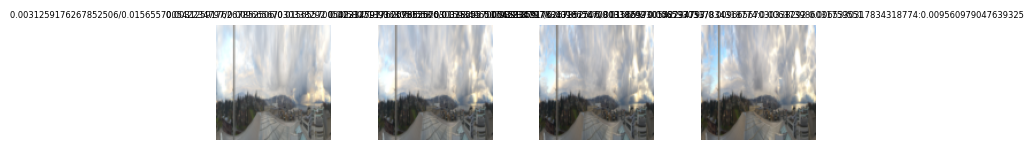

In [86]:
sample_size = 4

for i, sample in enumerate(ghi_dataset):
    print(i, sample[0].shape, sample[1].shape)#, sample[2].shape)

    ax = plt.subplot(1, sample_size, i + 1)
    plt.tight_layout()

    # Format the date as a string
    formatted_date = "{}/{}/{} {}:{}".format(sample[2],sample[3], sample[4], sample[5], sample[6])

    ax.set_title(formatted_date, fontsize=6)
    ax.axis('off')
    sample_display(sample[0],sample[-1]) #display image and label

    if i == (sample_size-1):
        plt.show()
        break

## Data management

The data need to be splitted between train and test set.

Here we define a function to split the dataset into a test set, a validation set and a train set.

We also define a function to split the dataset in a given site to choose the test set we want.

Note that we do not shuffle the data as it is time dependent. What is significant here is that we test for the last values of the set.


In [87]:
def split_at_location(dataset, location = 0, lenght = 100):
    """
      extract the test set at a givent location in the total dataset
        Arguments:
            location  (int) : position in the dataset to start to cut
            lenght (int) : lenght of the test set
        """
    train_idx = np.arange(len(dataset))
    # Calculate start and stop indices while preventing out-of-range
    start_idx = max(0,location)
    end_idx = min(len(dataset),location+lenght)

    subset = train_idx[start_idx:end_idx]

      # Create the modified training set without the 5%
    modified_train = np.concatenate([train_idx[:start_idx], train_idx[end_idx:]])

    return Subset(dataset, modified_train), Subset(dataset, subset)

def train_val_dataset(dataset,test_split=0.8, val_split=0.2):
    """
      split dataset in train set, validation set, test set
    """

    test_idx, train_idx = train_test_split(list(range(len(dataset))), test_size=test_split,shuffle=False)
    train_idx, val_idx = train_test_split(train_idx,test_size=val_split,shuffle=False)

    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

def shuffle(dataset) :

  train_idx = np.arange(len(dataset))
  random.shuffle(train_idx)
  print(train_idx)
  return Subset(dataset, train_idx)


In [88]:
location = 1270

ghi_train, ghi_test = split_at_location(ghi_dataset, location, 400)

print(len(ghi_train))
print(len(ghi_test))

# below : in case of only one validation set, no cross validation

#ghi_train ,ghi_val= split_at_location(ghi_train, 0, round(len(ghi_train)*0.10))

#define the loader !
#train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=32, dec = 32))
#test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=32, dec = 32))


10293
400


Finally we create the dataloader, to iterate on it as we compute each epoch.

We define a custom batch sampler because we need to conserve the order of the samples in each batch. Moreover, we want the stride between each batch to be one and not the batch size. Such that for a dataset = [1,2,3,4,5,6] and a batch size of 3 we get [1,2,3], [2,3,4], [3,4,5], [4,5,6] as batches

In [89]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler

class SequentialBatchSampler:
    def __init__(self, data_source, batch_size, dec):
        self.data_source = data_source
        self.batch_size = batch_size
        self.dec = dec

    def __iter__(self):
      i = 0
      while i <= len(self.data_source)-self.batch_size-1:
        yield self.data_source[i:i+self.batch_size]
        i += self.dec

## Models

we defined and tested several models for our purpose.

- Only taking in account the images, convolutionnal layer + LSTM
- Taking in account the images and meteo data (not implemented yet)
- Transformer (not implemented yet)

In [21]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(6, 16, kernel_size=3) # input channels to 6 because 2 images ! (RGBx2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout2d(p=0.3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout2d(p=0.1)
        self.lstm1 = nn.LSTM(32* 22* 22, 128, batch_first=False)
        self.lstm2 = nn.LSTM(128, 64, batch_first=False)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x1,x2): #x1 and x2 correspond to the 2 images
        x = torch.cat((x1, x2), dim=1)  # Concatenate along the channel dimension
        x = F.relu(self.conv1(x)) # add relu activation function
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, 32* 22* 22)
        x = x.unsqueeze(1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = F.relu(self.fc1(x[:, -1, :]))
        x = self.fc2(x)
        x = x.squeeze()
        return x


This neural network will take in account meteo data.

In [94]:
class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(6, 16, kernel_size=3) # input channels to 6 because 2 images ! (RGBx2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout2d(p=0.3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout2d(p=0.1)
        #self.linear_layer = nn.Linear(5, 32*22*22)  # 5 is the number of additional features
        self.lstm1 = nn.LSTM(32* 22* 22, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64*2, 1)

        # Skip connections
        self.skip_conv1 = nn.Conv2d(6, 32, kernel_size=1)  # Adjust channels as needed
        self.skip_conv2 = nn.Conv2d(32, 32, kernel_size=1)  # Adjust channels as needed

        # Additional features processing
        self.additional_fc1 = nn.Linear(9, 64)  # Adjust input size and output size
        self.additional_fc2 = nn.Linear(64, 64)  # Adjust output size


    def forward(self, x1,x2, day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir): #x1 and x2 correspond to the 2 images

        x = torch.cat((x1, x2), dim=1)  # Concatenate along the channel dimension

        #x_skip1 = F.relu(self.skip_conv1(x))  # Skip connection 1

        x = F.relu(self.conv1(x)) # add relu activation function
        x = self.bn1(x)

        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool2(x)
        x = self.drop2(x)

        #x_skip2 = F.relu(self.skip_conv2(x))  # Skip connection 2

        x = x.view(-1, 32* 22* 22)
        x = x.unsqueeze(1)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = F.relu(self.fc1(x[:, -1, :]))

        # Combine image features with skip connections
        #x_skip1 = x_skip1.view(x_skip1.size(0), -1).unsqueeze(2).unsqueeze(3)
        #x_skip2 = x_skip2.view(x_skip2.size(0), -1).unsqueeze(2).unsqueeze(3)
        #x = x + x_skip1 + x_skip2

        # Concatenate the additional features into a single tensor
        additional_features = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir), dim=1)

        additional_features = additional_features.to(torch.float32)  # Convert to torch.FloatTensor

        # Apply the linear layer to the concatenated additional features
        additional_features = F.relu(self.additional_fc1(additional_features))
        additional_features = F.relu(self.additional_fc2(additional_features))

        # Combine with additional features

        x_combined = torch.cat((x, additional_features*10), dim=1)

        # Fully connected layers
        x_combined = self.fc2(x_combined)
        x_combined = x_combined.squeeze()

        return x_combined

I asked ChatGPT to give me a basic transformer architecture for what we want

In [23]:
class TransformerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_layers, dropout):
        super(TransformerNet, self).__init__()

        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=input_size,
                nhead=num_heads,
                dim_feedforward=hidden_size,
                dropout=dropout
            ),
            num_layers=num_layers
        )

        # Fully-connected layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Embedding(256, 32)  # Assuming 8-bit images

        # Create two instances of the TransformerNet
        self.transformer_net1 = TransformerNet(input_size=32, hidden_size=64, num_heads=4, num_layers=2, dropout=0.1)
        self.transformer_net2 = TransformerNet(input_size=32, hidden_size=64, num_heads=4, num_layers=2, dropout=0.1)

    def forward(self, x1, x2):
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)

        # Reshape to (batch_size, sequence_length, input_size)
        x1 = x1.permute(0, 2, 1)
        x2 = x2.permute(0, 2, 1)

        # Forward through the Transformer networks
        x1 = self.transformer_net1(x1)
        x2 = self.transformer_net2(x2)

        # Concatenate the outputs
        x = torch.cat((x1, x2), dim=1)

        return x

## Training and validation step using Cross validation

In [95]:
def RMSELoss(yhat,y): #defining RMSE
    return torch.sqrt(torch.mean((yhat-y)**2))

def reset_weights(m):
  '''
    Method to reset the model weights between each fold or utilization
    Avoid weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def train_epoch(model, optimizer, criterion, train_loader, epoch, device):
  """
    method to train the model on a given training set
    return the loss at each step
  """
  # Set model to training mode (affects dropout, batch norm e.g.)
  model.train()
  loss_history = []
  lr_history = []
  # loop to get batch_idx, data and target from train_loader
  for batch_idx, (image0, image1, day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir, target) in enumerate(train_loader):

      # Move the data to the device
      image0,image1,day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir, target = image0.to(device),image1.to(device), day.to(device), month.to(device), year.to(device), hour.to(device), minute.to(device), GHI.to(device), air_temp.to(device), wind_speed.to(device), wind_dir.to(device), target.to(device)

      # Zero the gradients
      optimizer.zero_grad()
      # Compute model output
      output = model(image0,image1, day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir)
      output = output.to(torch.float64)
      # Compute loss
      loss = criterion(output, target)
      # Backpropagate loss
      loss.backward()
      # Perform an optimizer step
      optimizer.step()
      # Compute loss (float value, not a tensor)
      loss_float = loss.item()

      loss_history.append(loss_float)
  print(
    f"Train Epoch : {epoch}"
    f"train_loss = {np.mean(loss_history)} "
  )

  return loss_history

@torch.no_grad()
def validate(model, device, val_loader, criterion):
  """
    method to validate the model on a given validation set
    return the loss at each step
  """
  model.eval()  # Important: eval mode (affects dropout, batch norm etc)
  test_loss = 0
  history = []

  for image0, image1, target in val_loader:
    image0,image1, target = image0.to(device),image1.to(device), target.to(device)
    output = model(image0,image1)
    test_loss = criterion(output, target).item()
    history.append(test_loss)

  print(
    "Test set: Average loss: {:.4f}".format(
       np.mean(history),
       len(val_loader.dataset)
      )
  )
  return history

In [71]:
# parameter for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict( # how did you decice that ?
    lr=5e-4,
    weight_decay=1e-3,
)

model = Net()
model = model.to(device=device)

criterion = RMSELoss #criterion for the training

#parameter for the cross-validation
num_epochs = 25
folds = 4

# Define the K-fold Cross Validator
kfold = KFold(n_splits=folds, shuffle=True)

# initialize each variables
result_model = []
result_best_val_loss = []  # Initialize with positive infinity
result_best_epoch = []


#iterate on each fold
for fold, (train_ids, test_ids) in enumerate(kfold.split(ghi_train)):

  print("fold ", fold+1) # just by convenience, first fold, second fold....

  # prepare the train and validation set and corresponding loaders
  train = Subset(ghi_train, train_ids)
  test = Subset(ghi_train, test_ids)
  #define the loader
  train_loader = DataLoader(train, batch_sampler=SequentialBatchSampler(np.arange(len(train)), batch_size=32, dec = 32))
  val_loader = DataLoader(test, batch_sampler=SequentialBatchSampler(np.arange(len(test)), batch_size=32, dec = 32))

  #prepare the model
  model.apply(reset_weights)
  optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

  # ===== Train Model =====
  best_val_loss = float('inf')  # Initialize with positive infinity
  best_epoch = 0
  #train_loss_history = []
  train_loss_step = []
  #val_loss_history = []
  val_loss_step = []
  for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, optimizer, criterion, train_loader, epoch, device)
  #train_loss_history.extend(train_loss)
    train_loss_step.append(np.mean(train_loss))

    val_loss = validate(model, device, val_loader, criterion)
  #val_loss_history.extend(val_loss)
    loss = np.mean(val_loss)
    val_loss_step.append(loss)

  # Save the model with the lowest validation loss
    if loss < best_val_loss:
      best_val_loss = loss
      best_epoch = epoch
      best_model_state = model.state_dict()

  print("best loss",best_val_loss, "epoch", best_epoch)
  result_model.append(best_model_state)
  result_best_val_loss.append(best_val_loss)
  result_best_epoch.append(best_epoch)

  # ===== Plot training curves =====
  t_val = np.arange(1, num_epochs + 1)

# Increase the size of the plot
  plt.figure(figsize=(20, 16))

  plt.subplot(2, 3, 2)
  plt.plot(t_val, train_loss_step, label="Train")
  plt.plot(t_val, val_loss_step, label="Val")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

# define best parameters
mean_loss = np.mean(result_best_val_loss)
mean_epoch = math.ceil(np.mean(result_best_epoch))
print("best loss",np.mean(result_best_val_loss), "epoch", mean_epoch)


fold  1
Reset trainable parameters of layer = Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = LSTM(15488, 128)
Reset trainable parameters of layer = LSTM(128, 64)
Reset trainable parameters of layer = Linear(in_features=64, o

IndexError: ignored

## Train the final model

In [ ]:
# parameter for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict( # how did you decice that ?
    lr=5e-4,
    weight_decay=1e-3,
)

model = Net()
model = model.to(device=device)
model.apply(reset_weights)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)


criterion = RMSELoss #criterion for the training

#parameter
num_epochs = mean_epoch
#num_epochs = 25

#define the loader
ghi_train_shuffle = shuffle(ghi_train)
train_loader = DataLoader(ghi_train_shuffle, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train_shuffle)), batch_size=32, dec = 32))

# ===== Train Model =====
train_loss_history = []
train_loss_step = []
for epoch in range(1, num_epochs + 1):
  train_loss = train_epoch(model, optimizer, criterion, train_loader, epoch, device)
  train_loss_history.extend(train_loss)
  train_loss_step.append(np.mean(train_loss))

# ===== Plot training curves =====
t_val = np.arange(1, num_epochs + 1)

# Increase the size of the plot
plt.figure(figsize=(20, 16))

plt.subplot(2, 3, 2)
plt.plot(t_val, train_loss_step, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

t_train = np.arange(1, len(train_loss_history) + 1)/len(train_loss_history)*num_epochs

plt.subplot(2, 3, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


# Increase the size of the plot
plt.figure(figsize=(40, 16))


plt.subplot(2, 3, 2)
plt.plot(t_train[0:360], train_loss_history[0:360], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

plt.subplot(2, 3, 2)
plt.plot(t_train[-361:-1], train_loss_history[-361:-1], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

Reset trainable parameters of layer = Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = LSTM(15488, 128)
Reset trainable parameters of layer = LSTM(128, 64)
Reset trainable parameters of layer = Linear(in_features=64, out_featu

NameError: ignored

In [ ]:
# Increase the size of the plot
#plt.figure(figsize=(40, 16))

#t_valid = np.arange(1, len(val_loss_history) + 1)/len(val_loss_history)*num_epochs

#plt.subplot(2, 3, 2)
#plt.plot(t_valid, val_loss_history, label="Train")
#plt.legend()
#plt.xlabel("Epoch")
#plt.ylabel("Loss")

#plt.show()


# Increase the size of the plot
#plt.figure(figsize=(40, 16))

#t_valid = np.arange(1, len(val_loss_history) + 1)/len(val_loss_history)*num_epochs

#plt.subplot(2, 3, 2)
#plt.plot(t_valid[1:round(len(val_loss_history)/num_epochs*3)], val_loss_history[1:round(len(val_loss_history)/num_epochs)*3], label="Train")
#plt.legend()
#plt.xlabel("Epoch")
#plt.ylabel("Loss")

#plt.show()

## Test the model

In [ ]:
test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=32, dec = 32))

pred = []
truth = []
test_loss = []
model.eval()
for image0, image1, target in test_loader:
  image0,image1, target = image0.to(device),image1.to(device), target.to(device)
  output = model(image0,image1)
  pred.extend(output.tolist())
  truth.extend(target.tolist())
  test_loss.append(criterion(output, target).item())

Loss = np.mean(test_loss)

print("the test loss is ",Loss)
#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(pred, 'g', label = "Predictions")
plt.plot(truth, '--k',label = 'Truth')
plt.legend(loc = 'best')

ValueError: ignored

# Train Net2 (with other parameters)


In [ ]:
# parameter for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict( # how did you decice that ?
    lr=5e-4,
    weight_decay=1e-3,
)

model = Net2()
model = model.to(device=device)
model.apply(reset_weights)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)


criterion = RMSELoss #criterion for the training

#parameter
#num_epochs = mean_epoch
num_epochs = 25

#define the loader
ghi_train_shuffle = shuffle(ghi_train)
train_loader = DataLoader(ghi_train_shuffle, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train_shuffle)), batch_size=8, dec = 8))

# ===== Train Model =====
train_loss_history = []
train_loss_step = []
for epoch in range(1, num_epochs + 1):
  train_loss = train_epoch(model, optimizer, criterion, train_loader, epoch, device)
  train_loss_history.extend(train_loss)
  train_loss_step.append(np.mean(train_loss))

# ===== Plot training curves =====
t_val = np.arange(1, num_epochs + 1)

# Increase the size of the plot
plt.figure(figsize=(20, 16))

plt.subplot(2, 3, 2)
plt.plot(t_val, train_loss_step, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

t_train = np.arange(1, len(train_loss_history) + 1)/len(train_loss_history)*num_epochs

plt.subplot(2, 3, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


# Increase the size of the plot
plt.figure(figsize=(40, 16))


plt.subplot(2, 3, 2)
plt.plot(t_train[0:360], train_loss_history[0:360], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

plt.subplot(2, 3, 2)
plt.plot(t_train[-361:-1], train_loss_history[-361:-1], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

Reset trainable parameters of layer = Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = LSTM(15488, 128, batch_first=True)
Reset trainable parameters of layer = LSTM(128, 64, batch_first=True)
Reset trainable parameters of laye

# Test Net2

In [ ]:
test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=8, dec = 8))

pred = []
truth = []
test_loss = []
model.eval()
for image0,image1,day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir, target in test_loader:
  image0,image1,day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir, target = image0.to(device),image1.to(device), day.to(device), month.to(device), year.to(device), hour.to(device), minute.to(device), GHI.to(device), air_temp.to(device), wind_speed.to(device), wind_dir.to(device), target.to(device)
  output = model(image0,image1,day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir)

  pred.extend(output.tolist())
  truth.extend(target.tolist())
  test_loss.append(criterion(output, target).item())

Loss = np.mean(test_loss)

print("the test loss is ",Loss)
#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(pred, 'g', label = "Predictions")
plt.plot(truth, '--k',label = 'Truth')
plt.legend(loc = 'best')